In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat
from scipy.interpolate import interp1d
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# LOAD BOTTOM SLOPES (OLD)
# x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/slopes/CM26_global_slope.mat')
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/slopes/CM26_slope_rough_1degree.mat')
lon0 = x['lon'][:,0]
lat = x['lat'][:,0]
gamma0 = x['zonal'] # eastward 
alpha0 = x['meridional'] # northward 
roughness = x['rms_rough']
# realign so lon-grid goes from 0-360
roughness = np.concatenate((roughness[:,lon0 >= 0], roughness[:,lon0 < 0]),axis=1)
lon = np.concatenate((lon0[lon0 >= 0], lon0[lon0 < 0]+360))

alpha0 = np.concatenate((alpha0[:,lon0 >= 0], alpha0[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((gamma0[:,lon0 >= 0], gamma0[:,lon0 < 0]),axis=1)
slope = np.sqrt(alpha0**2 + gamma0**2)

In [33]:
cm26_slope_rough_fn = '/Users/jakesteinberg/Documents/CPT/vertical_structure/slopes/CM26_slope_rough_1degree.nc'
cm26_slope_rough = xr.open_dataset(cm26_slope_rough_fn)
roughness0 = cm26_slope_rough.roughness
lon0 = cm26_slope_rough.lon
lat = cm26_slope_rough.lat
roughness = np.concatenate((roughness0[:,lon0 >= 0], roughness0[:,lon0 < 0]),axis=1)
lon = np.concatenate((lon0[lon0 >= 0], lon0[lon0 < 0]+360))

alpha0 = np.concatenate((cm26_slope_rough.meridional[:,lon0 >= 0], cm26_slope_rough.meridional[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((cm26_slope_rough.zonal[:,lon0 >= 0], cm26_slope_rough.zonal[:,lon0 < 0]),axis=1)
alpha0 = np.concatenate((alpha0[:,lon0 >= 0], alpha0[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((gamma0[:,lon0 >= 0], gamma0[:,lon0 < 0]),axis=1)
slope = np.sqrt(alpha0**2 + gamma0**2)

In [6]:
cm26_scales_fn = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_scales_and_clusters.nc'
cm26_scales = xr.open_dataset(cm26_scales_fn)

lon01 = cm26_scales.xt_ocean.data
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = cm26_scales.yt_ocean.data

LE_scale = cm26_scales.LE_scale.data
LD_scale = cm26_scales.LD_QG.data
LRh_scale = cm26_scales.L_rhines.data
LE_scale = np.concatenate((LE_scale[:,lon01 >= 0], LE_scale[:,lon01 < 0]),axis=1)
LD_scale = np.concatenate((LD_scale[:,lon01 >= 0], LD_scale[:,lon01 < 0]),axis=1)
LRh_scale = np.concatenate((LRh_scale[:,lon01 >= 0], LRh_scale[:,lon01 < 0]),axis=1)
scale_ratio = LE_scale/LD_scale
scale_eq_ratio = LRh_scale/LD_scale

cluster_map = cm26_scales.clusters.data
cluster_map = np.concatenate((cluster_map[:,lon01 >= 0], cluster_map[:,lon01 < 0]),axis=1)

In [77]:
cm26_topoLR_fn = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_L_rhines.nc'
cm26_topoLR = xr.open_dataset(cm26_topoLR_fn)
LRh_topo_scale0 = cm26_topoLR.L_rhines_topo1.coarsen(xt_ocean=10,yt_ocean=10,boundary='exact').mean()
LRh_topo_scale = np.concatenate((LRh_topo_scale0[:,lon01 >= 0], LRh_topo_scale0[:,lon01 < 0]),axis=1)
scale_LRh_topo_ratio = LRh_topo_scale/LD_scale

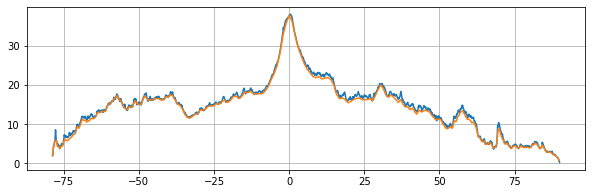

In [30]:
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(cm26_topoLR.yt_ocean,cm26_topoLR.L_rhines_topo1.mean(dim=['xt_ocean']))
ax.plot(lat1,LRh_topo_scale.mean(dim=['xt_ocean']))
ax.grid()

In [23]:
cm26_ice_fn = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_ice_mask.nc'
cm26_ice = xr.open_dataset(cm26_ice_fn)
ice_mask0 = cm26_ice.EXT
ice_mask = np.concatenate((ice_mask0[:,lon01 >= 0], ice_mask0[:,lon01 < 0]),axis=1)

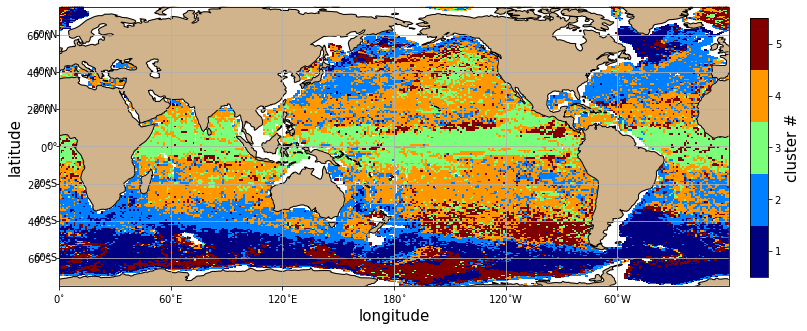

In [20]:
data_coords = {'latitude': lat1, 'longitude': lon1}
cm_da = xr.DataArray(data=cluster_map, dims=['latitude', 'longitude'], coords=data_coords) 
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
cc = cm_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet',5), add_colorbar=False,vmin=0,vmax=5)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True);
gl.xlabels_top = False; gl.xlabels_bottom = False; ax.set_ylim([-75,75])
ax.set_yticks(np.arange(-60,80,20));
ax.set_yticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$','20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
ax.set_xticks(np.arange(-180,180,60))
ax.set_xticklabels(['0$^{\circ}$','60$^{\circ}$E','120$^{\circ}$E','180$^{\circ}$','120$^{\circ}$W','60$^{\circ}$W'])
# ax.set_title('NOAA GFDL CM2.6 Mean Barotropic KE [m$^{2}$s$^{-2}$]',fontsize=15)
ax.set_ylabel('latitude',fontsize=15)
ax.set_xlabel('longitude',fontsize=15)

cbpos = [0.925, 0.2, 0.02, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='cluster #', ticks=np.arange(0.5,5,1))
cb.ax.set_yticklabels(['1','2','3','4','5']); cb.set_label('cluster #',fontsize=15)
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2023_02_14/clusters5_e.jpg', dpi=300)

(-75.0, 75.0)

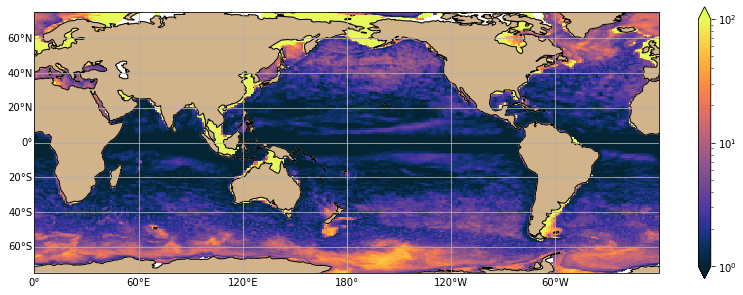

In [8]:
data_coords = {'latitude': lat1, 'longitude': lon1}
sr_da = xr.DataArray(data=scale_ratio, dims=['latitude', 'longitude'], coords=data_coords) 
LRh_da = xr.DataArray(data=LE_scale, dims=['latitude', 'longitude'], coords=data_coords) 
f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
sr_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.thermal, add_colorbar=True,norm=LogNorm(vmin=1,vmax=100))
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True);
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-75,75])
# ax.set_title('NOAA GFDL CM2.6 Mean Barotropic KE [m$^{2}$s$^{-2}$]',fontsize=15)

In [12]:
# LOAD CM UV compute MEKE 
cm26_u_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_u_1year.nc'
cm26_v_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_v_1year.nc'
cmU = xr.open_dataset(cm26_u_path); cmV = xr.open_dataset(cm26_v_path)
lon0UV = cmU.xu_ocean.data
U = np.concatenate((cmU.u_full[:,:,:,lon0UV >= 0].data, cmU.u_full[:,:,:,lon0UV < 0].data),axis=3)
V = np.concatenate((cmV.v_full[:,:,:,lon0UV >= 0].data, cmV.v_full[:,:,:,lon0UV < 0].data),axis=3)
EKE0 = 0.5*(np.nanmean(U[:,0],axis=0)**2 + np.nanmean(V[:,0],axis=0)**2)
lonUV = np.concatenate((lon0UV[lon0UV >= 0], lon0UV[lon0UV < 0]+360))
latUV = cmV.yu_ocean.data
data_coords = {'latitude': latUV, 'longitude': lonUV}
EKE = xr.DataArray(data=EKE0, dims=['latitude', 'longitude'], coords=data_coords) 
z_mid = cmU.st_ocean.data
z_edge = np.concatenate((np.array([0]), z_mid[0:-1] + (z_mid[1:]-z_mid[0:-1])/2))

# compute u prime so we can generate BT/BC ratios for EKE (not total KE)
U_pr = U - np.nanmean(U,axis=0); V_pr = V - np.nanmean(V,axis=0)

In [13]:
# bathy 
cm26_bathy_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_depth.nc'
cmbathy = xr.open_dataset(cm26_bathy_path)
depth = cmbathy.depth.data[::10,::10]
depth = np.concatenate((depth[:,lon0UV >= 0], depth[:,lon0UV < 0].data),axis=1)

In [14]:
# my own BT/BC ratio (set up to do either KE or EKE)
BTU = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BTV = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
MKE_t = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BTKE = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BCKE = np.nan*np.ones((np.shape(U)[0],np.shape(U)[2],np.shape(U)[3]))
BCU = np.nan*np.ones(np.shape(U)); BCV = np.nan*np.ones(np.shape(U))
for t in range(np.shape(U)[0]):
    for i in range(np.shape(U)[2]):
        for j in range(np.shape(U)[3]):
            this_u = U_pr[t,:,i,j]; this_v = V_pr[t,:,i,j]; good = ~np.isnan(this_u)
            if np.sum(good) > 3:
                this_z = np.concatenate((z_edge[good], np.array([depth[i,j]])))
                this_dz = this_z[1:]-this_z[0:-1]
                BTU[t,i,j] = (1/depth[i,j])*np.sum(this_u[good]*this_dz)
                BTV[t,i,j] = (1/depth[i,j])*np.sum(this_v[good]*this_dz)   
                BCU[t,good,i,j] = this_u[good] - BTU[t,i,j]
                BCV[t,good,i,j] = this_v[good] - BTV[t,i,j]   
                MKE_t[t,i,j] = 0.5*(np.sum((this_u[good]**2)*this_dz) +  np.sum((this_v[good]**2)*this_dz))
                BTKE[t,i,j] = 0.5*(BTU[t,i,j]**2 + BTV[t,i,j]**2)
                BCKE[t,i,j] = (1/depth[i,j])*np.sum( 0.5*((this_u[good] - BTU[t,i,j])**2 + (this_v[good] - BTV[t,i,j])**2)*this_dz )

In [15]:
# time mean 
BT_BC_EKE = np.nanmean(BTKE,axis=0)/np.nanmean(BCKE,axis=0)
MKE = np.nanmean(MKE_t,axis=0)

In [17]:
np.shape(BT_BC_EKE)

(270, 360)

(-75.0, 75.0)

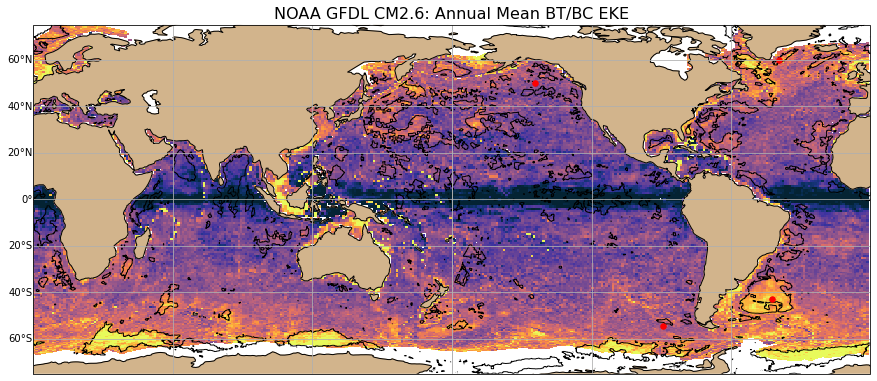

In [25]:
f, ax = plt.subplots(1,1,figsize=(15,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax.pcolor(lonUV,latUV,BT_BC_EKE*ice_mask,cmap=cmo.cm.thermal,norm=LogNorm(vmin=0.1, vmax=10),transform=ccrs.PlateCarree())
ax.contour(lon,lat, roughness, levels=[50], colors='k', linewidths=0.95, transform=ccrs.PlateCarree())
ax.scatter(360-39.4818, 59.98,s=30,color='r',transform=ccrs.PlateCarree(),zorder=2) # irm
ax.scatter(360-144.4788, 50.04,s=30,color='r',transform=ccrs.PlateCarree(),zorder=2) # pap
ax.scatter(360-89.24, -54.47,s=30,color='r',transform=ccrs.PlateCarree(),zorder=2) # so
ax.scatter(360-42.4985, -42.98,s=30,color='r',transform=ccrs.PlateCarree(),zorder=2) # arb

ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines(); 
gl = ax.gridlines(draw_labels=True)
ax.set_title('NOAA GFDL CM2.6: Annual Mean BT/BC EKE',fontsize=16) # (w/ roughness < 50 m)
gl.xlabels_top = False; gl.xlabels_bottom = False; gl.ylabels_right = False

# ax.set_yticks([-60,-40,-20,0,20,40,60])
# ax.set_yticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$','20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
ax.set_ylabel('Latitude',fontsize=14)
# ax.set_xticks([-180,-120,-60,0,60,120])
# ax.set_xticklabels(['0$^{\circ}$','60$^{\circ}$E','120$^{\circ}$E','180$^{\circ}$','120$^{\circ}$W','60$^{\circ}$W'])
ax.set_xlabel('Longitude',fontsize=14)

# cbpos = [0.92, 0.15, 0.018, 0.5]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(btc, cax=cax, orientation='vertical', label='BT/BC KE', extend='both')
# cb.set_label(label='BT/BC KE', color='k', fontsize=11)
ax.set_ylim([-75,75])
# f.savefig('/Users/jakesteinberg/Documents/CPT/manuscript_vertical_structure/f9_btbcke_ratio.jpg', dpi=350)

In [51]:
# option to nan out ice regions
BT_BC_EKE_im = BT_BC_EKE*ice_mask

In [44]:
print(latUV[26])
print(latUV[182])
# print(lonUV[100])
# print(lonUV[150])
print(lon0UV[100])
print(lon0UV[150])

-70.10527986223863
49.801689388127535
100.10000000000457
150.1000000000028


In [ ]:
# pacific sub-domain 
lat_s = 26 ()
lat_n = 182
lon_w = 100
lon_e = 150 

In [78]:
n_clusters = 5; Lon,Lat = np.meshgrid(lon1,lat1)
rough_in=[]; slope_in=[]; btbc_eke_in=[];
scale_in=[]; scale_eq_in=[]; scale_topo_in=[];
Lon_in=[];Lat_in=[];
for i in range(n_clusters):
    cluster_loc_i = np.where(cluster_map == i)
    btbc_eke_in_i = []; rough_in_i = []; slope_in_i = []; 
    scale_in_i = []; scale_eq_in_i = []; scale_topo_in_i = [];
    lon_in_i = []; lat_in_i = [];
    for j in tqdm(range(len(cluster_loc_i[0]))):
        this_lon = Lon[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        this_lat = Lat[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        
        r_lon_in = np.where((lon > (this_lon - 0.2)) & (lon < (this_lon + 0.2)))
        r_lat_in = np.where((lat > (this_lat - 0.2)) & (lat < (this_lat + 0.2)))
        rough_in_i.append(np.nanmean(roughness[r_lat_in][:,r_lon_in]))   
        slope_in_i.append(np.nanmean(slope[r_lat_in][:,r_lon_in]))
        
        e2_lon_in = np.where((lonUV > (this_lon - 0.45)) & (lonUV < (this_lon + 0.45)))
        e2_lat_in = np.where((latUV > (this_lat - 0.45)) & (latUV < (this_lat + 0.45)))
        btbc_eke_in_i.append(np.nanmean(BT_BC_EKE_im[e2_lat_in][:,e2_lon_in])) 
        
        m_lon_in = np.where((lon1 > (this_lon - 0.2)) & (lon1 < (this_lon + 0.2)))
        m_lat_in = np.where((lat1 > (this_lat - 0.2)) & (lat1 < (this_lat + 0.2)))        
        scale_in_i.append(np.nanmean(scale_ratio[m_lat_in][:,m_lon_in]))
        scale_eq_in_i.append(np.nanmean(scale_eq_ratio[m_lat_in][:,m_lon_in]))
        scale_topo_in_i.append(np.nanmean(scale_LRh_topo_ratio[m_lat_in][:,m_lon_in]))
        lon_in_i.append(this_lon)
        lat_in_i.append(this_lat)
        
    btbc_eke_in.append(btbc_eke_in_i)    
    rough_in.append(rough_in_i)
    slope_in.append(slope_in_i)
    scale_in.append(scale_in_i)
    scale_eq_in.append(scale_eq_in_i)
    scale_topo_in.append(scale_topo_in_i)
    Lon_in.append(lon_in_i)
    Lat_in.append(lat_in_i)

100%|██████████| 7971/7971 [00:06<00:00, 1222.62it/s]


In [157]:
n_roughs = 12
roughs = np.linspace(0,500,n_roughs+1)
rough_colors = plt.get_cmap('RdBu_r',n_roughs)

n_roughs_sm = 12
roughs_sm = np.linspace(0,100,n_roughs+1)
rough_colors_sm = plt.get_cmap('Blues_r',n_roughs_sm)

n_roughs_ro = 12
roughs_ro = np.linspace(100,400,n_roughs+1)
rough_colors_ro = plt.get_cmap('Reds',n_roughs_ro)

n_slopes = 24
slopes = np.linspace(0,0.01,n_slopes+1)
slope_colors = plt.get_cmap('RdBu_r',n_slopes)

n_decays = 6
decays = np.linspace(0,200,n_decays+1)
decay_colors = plt.get_cmap('cool',n_decays)

n_mkes = 6
mkes = np.linspace(0,15,n_mkes+1)
mke_colors = plt.get_cmap('cool',n_mkes)

n_lats = 12
lats = np.linspace(0,75,n_lats+1)
lat_colors = plt.get_cmap('BrBG',n_lats)

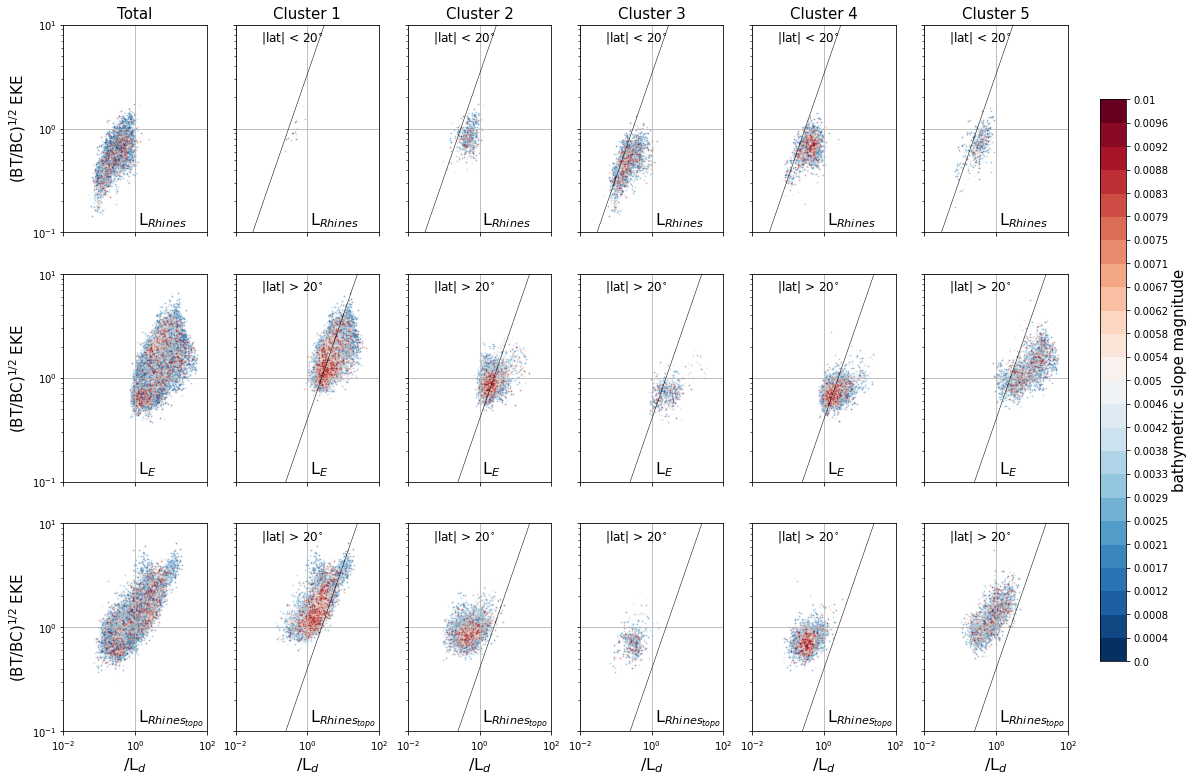

In [159]:
tp = 'slope'
zone_div = 20
f, ax = plt.subplots(3,n_clusters+1,figsize=(18,13));
ax[0,0].grid(); ax[1,0].grid(); ax[2,0].grid();
###### Energy containing scale (mid latitude smooth)
for i in range(n_clusters):
    these_lats = np.array(Lat_in[i])
    these_btbc = np.array(btbc_eke_in[i]); these_scales = np.array(scale_in[i]); 
    these_roughs = np.array(rough_in[i]); these_slopes = np.array(slope_in[i])
    
    inn_l_hl = (np.abs(these_lats) > zone_div) 
    these_scales_f = these_scales[inn_l_hl]; these_btbc_f = these_btbc[inn_l_hl]; these_lats_f = these_lats[inn_l_hl]
    these_roughs_f = these_roughs[inn_l_hl]; these_slopes_f = these_slopes[inn_l_hl];
    
    ax[1,i+1].plot([0.25,25],[0.1,10],color='k',linewidth=0.5)
    # -- COLOR BY ROUGHNESS --
    if tp == 'rough':
        for j in range(n_roughs):
            inn = (these_roughs_f > roughs[j]) & (these_roughs_f < roughs[j+1])
            ax[1,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=rough_colors(j),alpha=0.3)
            ax[1,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=rough_colors(j),alpha=0.3)
    # -- COLOR BY SLOPE --
    if tp == 'slope':
        for j in range(n_slopes):
            inn = (these_slopes_f > slopes[j]) & (these_slopes_f < slopes[j+1])
            ax[1,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=slope_colors(j),alpha=0.3)
            ax[1,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=slope_colors(j),alpha=0.3)
    # -- COLOR BY LATITUDE -- 
    if tp == 'lat':
        for j in range(n_lats):
            inn = (np.abs(these_lats_f) > lats[j]) & (np.abs(these_lats_f) < lats[j+1])
            ax[1,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=lat_colors(j),alpha=0.2)
            ax[1,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=lat_colors(j),alpha=0.2)
        
    ax[1,i+1].text(1.2*10**0,1.2*10**(-1),r'L$_E$',fontsize=16)
    # ax[1,i+1].set_xlabel('L$_e$/L$_d$',fontsize=13,fontweight='bold'); 
    ax[1,i+1].set_xscale('log'); ax[1,i+1].set_yscale('log')
    ax[1,i+1].set_xlim([0.01,100]); ax[1,i+1].set_ylim([0.1,10]); ax[0,i+1].grid()
    ax[1,i+1].text(0.05,7,'|lat| > '+str(zone_div)+'$^{\circ}$',fontsize=12)
    ax[1,i+1].set_yticklabels(''); ax[1,i+1].set_xticklabels('')

###### Rhines Scale (at low latitudes)
for i in range(n_clusters):
    these_lats = np.array(Lat_in[i]); 
    these_btbc = np.array(btbc_eke_in[i]); these_scales = np.array(scale_eq_in[i]); 
    these_roughs = np.array(rough_in[i]); these_slopes = np.array(slope_in[i])
    
    inn_l_eq = (np.abs(these_lats) < zone_div) & (np.abs(these_lats) > 1.5)
    these_scales_f = these_scales[inn_l_eq]; these_btbc_f = these_btbc[inn_l_eq]; these_lats_f = these_lats[inn_l_eq]
    these_roughs_f = these_roughs[inn_l_eq]; these_slopes_f = these_slopes[inn_l_eq];
    
    ax[0,i+1].plot([3*10**-2,3*10**0],[1*10**(-1),1*10**1],color='k',linewidth=0.5)
    # -- COLOR BY ROUGHNESS --
    if tp == 'rough':
        for j in range(n_roughs):
            inn = (these_roughs_f > roughs[j]) & (these_roughs_f < roughs[j+1])
            ax[0,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=rough_colors(j),alpha=0.3)
            ax[0,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=rough_colors(j),alpha=0.3)
    # -- COLOR BY SLOPE -- 
    if tp == 'slope':
        for j in range(n_slopes):
            inn = (these_slopes_f > slopes[j]) & (these_slopes_f < slopes[j+1])
            ax[0,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=slope_colors(j),alpha=0.3)
            ax[0,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=slope_colors(j),alpha=0.3)
    # -- COLOR BY LATITUDE --
    if tp == 'lat':
        for j in range(n_lats):
            inn = (np.abs(these_lats_f) > lats[j]) & (np.abs(these_lats_f) < lats[j+1])
            ax[0,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=lat_colors(j),alpha=0.2)
            ax[0,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=lat_colors(j),alpha=0.2)
    
    ax[0,i+1].text(1.2*10**0,1.2*10**(-1),r'L$_{Rhines}$',fontsize=16)
    # ax[0,i+1].set_xlabel('L$_{Rh}$/L$_d$',fontsize=13,fontweight='bold'); 
    ax[0,i+1].set_xscale('log'); ax[0,i+1].set_yscale('log')
    ax[0,i+1].set_xlim([0.01,100]); ax[0,i+1].set_ylim([0.1,10]); ax[0,i+1].grid()  
    ax[0,i+1].set_title('Cluster '+str(i+1),fontsize=15); 
    ax[0,i+1].text(0.05,7,'|lat| < '+str(zone_div)+'$^{\circ}$',fontsize=12)
    ax[0,i+1].set_yticklabels(''); ax[0,i+1].set_xticklabels('')
    
###### topographic Rhines Scale (mid latitude rough)
for i in range(n_clusters):
    these_lats = np.array(Lat_in[i]); 
    these_btbc = np.array(btbc_eke_in[i]); these_scales = np.array(scale_topo_in[i]); 
    these_roughs = np.array(rough_in[i]); these_slopes = np.array(slope_in[i])
    
    inn_l_hl = (np.abs(these_lats) > zone_div) 
    these_scales_f = these_scales[inn_l_hl]; these_btbc_f = these_btbc[inn_l_hl]; these_lats_f = these_lats[inn_l_hl]
    these_roughs_f = these_roughs[inn_l_hl]; these_slopes_f = these_slopes[inn_l_hl];
    
    # ax[2,i+1].plot([3*10**-2,3*10**0],[1*10**(-1),1*10**1],color='k',linewidth=0.5)
    ax[2,i+1].plot([0.25,25],[0.1,10],color='k',linewidth=0.5)
    # -- COLOR BY ROUGHNESS --
    if tp == 'rough':
        for j in range(n_roughs):
            inn = (these_roughs_f > roughs[j]) & (these_roughs_f < roughs[j+1])
            ax[2,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=rough_colors(j),alpha=0.3)
            ax[2,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=rough_colors(j),alpha=0.3) 
    # -- COLOR BY SLOPE --  
    if tp == 'slope':
        for j in range(n_slopes):
            inn = (these_slopes_f > slopes[j]) & (these_slopes_f < slopes[j+1])
            ax[2,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=slope_colors(j),alpha=0.3)
            ax[2,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=slope_colors(j),alpha=0.3)
    # -- COLOR BY LATITUDE -- 
    if tp == 'lat':
    for j in range(n_lats):
        inn = (np.abs(these_lats_f) > lats[j]) & (np.abs(these_lats_f) < lats[j+1])
        ax[2,i+1].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=lat_colors(j),alpha=0.2)
        ax[2,0].scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),s=1,color=lat_colors(j),alpha=0.2)
    
    ax[2,i+1].text(1.2*10**0,1.2*10**(-1),r'L$_{Rhines_{topo}}$',fontsize=16)
    ax[2,i+1].set_xlabel('/L$_d$',fontsize=16); 
    ax[2,i+1].set_xscale('log'); ax[2,i+1].set_yscale('log')
    ax[2,i+1].set_xlim([0.01,100]); ax[2,i+1].set_ylim([0.1,10]); ax[2,i+1].grid()  
    ax[2,i+1].text(0.05,7,'|lat| > '+str(zone_div)+'$^{\circ}$',fontsize=12)
    ax[2,i+1].set_yticklabels(''); 

ax[0,0].set_title('Total',fontsize=15);
ax[0,0].set_xlim([0.01,100]); ax[0,0].set_ylim([0.1,10]);
ax[0,0].set_xscale('log'); ax[0,0].set_yscale('log');
ax[0,0].text(1.2*10**0,1.2*10**(-1),r'L$_{Rhines}$',fontsize=16)
ax[0,0].set_xticklabels('')

ax[1,0].set_xlim([0.01,100]); ax[1,0].set_ylim([0.1,10]);
ax[1,0].set_xscale('log'); ax[1,0].set_yscale('log'); 
ax[1,0].text(1.2*10**0,1.2*10**(-1),r'L$_E$',fontsize=16)
ax[1,0].set_xticklabels('')

ax[2,0].set_xlim([0.01,100]); ax[2,0].set_ylim([0.1,10]);
ax[2,0].set_xscale('log'); ax[2,0].set_yscale('log'); 
ax[2,0].text(1.2*10**0,1.2*10**(-1),r'L$_{Rhines_{topo}}$',fontsize=16)
ax[2,0].set_xlabel('/L$_d$',fontsize=16);

ax[0,0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=15); 
ax[1,0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=15); 
ax[2,0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=15);
ax[0,1].grid(); ax[0,2].grid(); ax[0,3].grid(); ax[0,4].grid(); ax[0,5].grid();
ax[1,1].grid(); ax[1,2].grid(); ax[1,3].grid(); ax[1,4].grid(); ax[1,5].grid();

# COLORBAR
cbpos = [0.925, 0.2, 0.02, 0.6]; cax = f.add_axes(cbpos); 
if tp == 'rough':
    cc = plt.scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),c=np.sqrt(these_btbc_f[inn]),s=0,cmap=rough_colors)
    cb = f.colorbar(cc, cax=cax, orientation='vertical', \
                    ticks=np.linspace(np.nanmin(np.sqrt(these_btbc_f[inn])),np.nanmax(np.sqrt(these_btbc_f[inn])),n_roughs+1))
    cb.set_label('bathymetric roughness [m]',fontsize=15)
    rough_strings = []
    for i in range(len(roughs)):
        rough_strings.append(str(np.int(roughs[i])));
    cb.ax.set_yticklabels(rough_strings);

if tp == 'slope':
    cc = plt.scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),c=np.sqrt(these_btbc_f[inn]),s=0,cmap=slope_colors)
    cb = f.colorbar(cc, cax=cax, orientation='vertical', \
                    ticks=np.linspace(np.nanmin(np.sqrt(these_btbc_f[inn])),np.nanmax(np.sqrt(these_btbc_f[inn])),n_slopes+1))
    cb.set_label('bathymetric slope magnitude',fontsize=15)
    slope_strings = []
    for i in range(len(slopes)):
        slope_strings.append(str(np.round(slopes[i],4)));
    cb.ax.set_yticklabels(slope_strings);

if tp == 'lat':
    cc = plt.scatter(these_scales_f[inn],np.sqrt(these_btbc_f[inn]),c=np.sqrt(these_btbc_f[inn]),s=0,cmap=lat_colors)
    cb = f.colorbar(cc, cax=cax, orientation='vertical', \
                    ticks=np.linspace(np.nanmin(np.sqrt(these_btbc_f[inn])),np.nanmax(np.sqrt(these_btbc_f[inn])),n_lats+1))
    cb.set_label('|latitude|',fontsize=15)
    lat_strings = []
    for i in range(len(lats)):
        lat_strings.append(str(np.round(lats[i],1)));
    cb.ax.set_yticklabels(lat_strings);

f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2023_05_08_AM_whoi/scales_by_cluster_lat_' + tp + '.jpg', dpi=400)

In [136]:
np.sqrt(these_btbc_f[inn])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
f, (ax,ax2) = plt.subplots(1,2,figsize=(6,4))
for i in range(0,1):
    these_lats = np.array(Lat_in[i])
    these_btbc = np.array(btbc_eke_in[i])
    these_scales = np.array(scale_in[i])
    these_roughs = np.array(rough_in[i])
    ax.plot([0.25,25],[0.1,10],color='k',linewidth=0.5)
    inn = these_roughs < 150
    ax.scatter(these_scales[inn],np.sqrt(these_btbc[inn]),s=1,color='k',alpha=0.3)
    ax2.plot([0.25,25],[0.1,10],color='k',linewidth=0.5)
    inn = these_roughs > 150
    ax2.scatter(these_scales[inn],np.sqrt(these_btbc[inn]),s=1,color='k',alpha=0.3)
ax.set_xlabel('L$_e$/L$_d$',fontsize=15); 
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim([0.1,1000]); ax.set_ylim([0.1,10])
ax.set_title('cluster'+str(i+1),fontsize=15); ax.grid()  
ax2.set_xlabel('L$_e$/L$_d$',fontsize=15); 
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlim([0.1,1000]); ax2.set_ylim([0.1,10])
ax2.set_title('cluster'+str(i+1),fontsize=15); ax2.grid() 

In [ ]:
# cc = plt.scatter(these_scales,np.sqrt(these_btbc),c=np.abs(these_lats),s=0,cmap=plt.get_cmap('Spectral',n_lats))
# cbpos = [0.925, 0.2, 0.02, 0.6]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(cc, cax=cax, orientation='vertical', label='|latitude|', ticks=np.linspace(0,90,n_lats+1))
# lat_strings = []
# for i in range(len(lats)):
#     lat_strings.append(str(np.int(lats[i])));
# cb.ax.set_yticklabels(lat_strings);

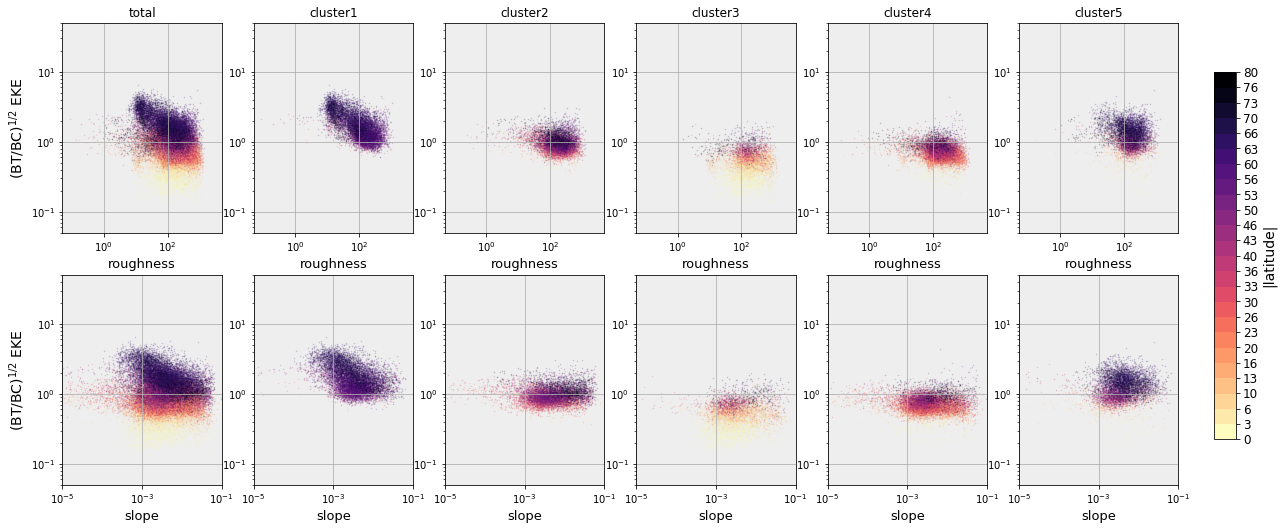

In [23]:
n_lats = 24
lats = np.linspace(0,80,n_lats+1)
lat_colors = plt.get_cmap('magma_r',n_lats)

f, gax = plt.subplots(2,n_clusters+1,figsize=(20,8.5)); # gax = ax.flatten()
x_bounds = [0.05,5000] # N2 = [1,500], MKE = [0.01,100], 
slope_bounds = [0.00001,0.1]
for i in range(n_clusters):
    these_lats = np.array(Lat_in[i])
    these_btbc = np.array(btbc_eke_in[i])
    # these_bot = np.array(botke_in[i])
    these_scales = np.array(scale_in[i])
    these_roughs = np.array(rough_in[i])
    these_slopes = np.array(slope_in[i])
    # these_decays = np.array(decay_in[i])
    # these_mkes = np.array(mke_in[i])
    # these_eoff = np.array(EOFf_in[i])
    
    for j in range(n_lats):
        inn = (np.abs(these_lats) > lats[j]) & (np.abs(these_lats) < lats[j+1])
        gax[0,i+1].scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        gax[0,0].scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        gax[1,i+1].scatter(these_slopes[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        gax[1,0].scatter(these_slopes[inn],np.sqrt(these_btbc[inn]),s=0.3,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_roughs[inn],np.sqrt(these_bot[inn]),s=1,color=lat_colors(j),alpha=0.2)
        # gax[0].scatter(these_roughs[inn],np.sqrt(these_bot[inn]),s=1,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_decays[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.2)
        # gax[0].scatter(these_decays[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.2)
        
        # gax[i+1].scatter(these_mkes[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.3)
        # gax[0].scatter(these_mkes[inn],np.sqrt(these_btbc[inn]),s=1,color=lat_colors(j),alpha=0.3)
        
    gax[0,i+1].set_yscale('log'); gax[0,i+1].set_ylim([0.05,50]); gax[0,i+1].grid()
    gax[1,i+1].set_yscale('log'); gax[1,i+1].set_ylim([0.05,50]); gax[1,i+1].grid()
    
    gax[0,i+1].set_xlim(x_bounds); gax[0,i+1].set_xscale('log')
    gax[0,i+1].set_xlabel('roughness',fontsize=13)
    gax[1,i+1].set_xlim(slope_bounds); gax[1,i+1].set_xscale('log')
    gax[1,i+1].set_xlabel('slope',fontsize=13)
    
    # gax[i+1].set_xlabel('N2 decay ratio',fontsize=14)
    # gax[i+1].set_xlabel('MKE',fontsize=14)
    
    gax[0,i+1].set_facecolor('#eeeeee')
    gax[1,i+1].set_facecolor('#eeeeee')
    gax[0,i+1].set_title('cluster'+str(i+1))
    
gax[0,0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=14); gax[0,0].set_ylim([0.05,50])
gax[1,0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=14); gax[1,0].set_ylim([0.05,50])
# gax[0,0].set_ylabel('EOF$_1$ decay',fontsize=14); gax[0,0].set_ylim([0.05,50])
# gax[1,0].set_ylabel('EOF$_1$ decay',fontsize=14); gax[1,0].set_ylim([0.05,50])
gax[0,0].set_yscale('log'); gax[0,0].grid()
gax[1,0].set_yscale('log'); gax[1,0].grid()
# gax[0].set_ylabel('(bottomuv)$^{1/2}$ ',fontsize=14)
# gax[0].set_ylim([0.001,1])

gax[0,0].set_xlim(x_bounds)
gax[0,0].set_xlabel('roughness',fontsize=13)
gax[1,0].set_xlim(slope_bounds)
gax[1,0].set_xlabel('slope',fontsize=13)
# gax[0].set_xlabel('N2 decay ratio',fontsize=14)
# gax[0].set_xlabel('MKE',fontsize=14)

gax[0,0].set_xscale('log'); gax[0,0].set_facecolor('#eeeeee'); gax[0,0].set_title('total')
gax[1,0].set_xscale('log'); gax[1,0].set_facecolor('#eeeeee'); 

cc = plt.scatter(these_roughs[inn],np.sqrt(these_btbc[inn]),c=these_lats[inn],s=0,cmap=plt.get_cmap('magma_r',n_lats))
cbpos = [0.925, 0.2, 0.015, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', ticks=np.linspace(np.nanmin(these_lats[inn]),np.nanmax(these_lats[inn]),n_lats+1))
cb.set_label('|latitude|',fontsize=14)
lat_strings = []
for i in range(len(lats)):
    lat_strings.append(str(np.int(lats[i])));
cb.ax.set_yticklabels(lat_strings,fontsize=12);
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2023_02_14/clusters5_e_roughness_slope.jpg', dpi=300)

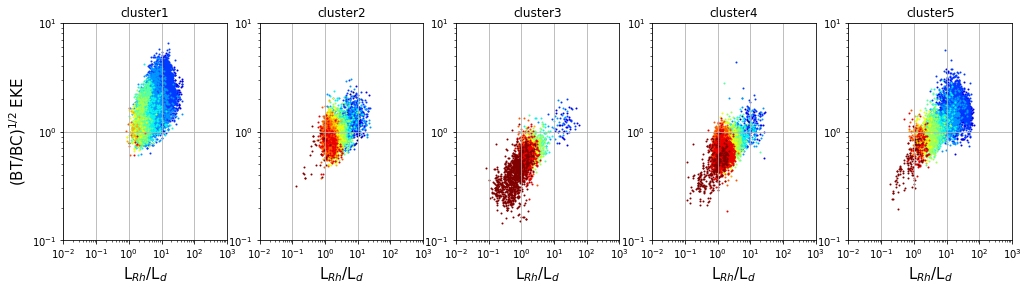

In [87]:
f, ax = plt.subplots(1,5,figsize=(17,4)); gax = ax.flatten()
for i in range(n_clusters):
    these_lats = np.array(Lat_in[i])
    this_btbc = np.array(btbc_eke_in[i])
    this_scales = np.array(scale_in[i])
    this_eq_scales = np.array(scale_eq_in[i])
    these_roughs = np.array(rough_in[i])
    
    # inn = (these_roughs < 100) 
    # gax[i].scatter(this_eq_scales[inn],np.sqrt(this_btbc[inn]),s=1,color='r',alpha=0.1)
    # inn2 = (these_roughs > 100) 
    # gax[i].scatter(this_eq_scales[inn2],np.sqrt(this_btbc[inn2]),s=1,color='b',alpha=0.1)
    # gax[i].plot([0.25,25],[0.1,10],color='k',linewidth=0.5)
    
    # for j in range(n_roughs):
    #     inn = (these_roughs > roughs[j]) & (these_roughs < roughs[j+1])
    #     gax[i].scatter(this_scales[inn],np.sqrt(this_btbc[inn]),s=1,color=rough_colors(j),alpha=0.2)
    for j in range(n_lats):
        inn = (these_lats > lats[j]) & (these_lats < lats[j+1])
        gax[i].scatter(this_scales[inn],np.sqrt(this_btbc[inn]),s=1,color=lat_colors(j))
        
    gax[i].set_xlabel('L$_{Rh}$/L$_d$',fontsize=15); 
    gax[i].set_xscale('log'); gax[i].set_yscale('log')
    gax[i].set_xlim([0.01,1000]); gax[i].set_ylim([0.1,10])
    gax[i].set_title('cluster'+str(i+1));gax[i].grid()    
gax[0].set_ylabel('(BT/BC)$^{1/2}$ EKE',fontsize=15); 